<a href="https://colab.research.google.com/github/igijon/PyTorch_Fundamentos/blob/main/02_pytorch_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be a multiple things as the options).



## 1. Make classification data and get it ready

In [3]:
import sklearn

In [4]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42) # Le damos un poco de ruido para darle un poco de aleatoriedad
len(X), len(y)


(1000, 1000)

In [5]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [6]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X0": X[:, 0],
                        "X1": X[:, 1],
                        "label": y})
circles.head(10)

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


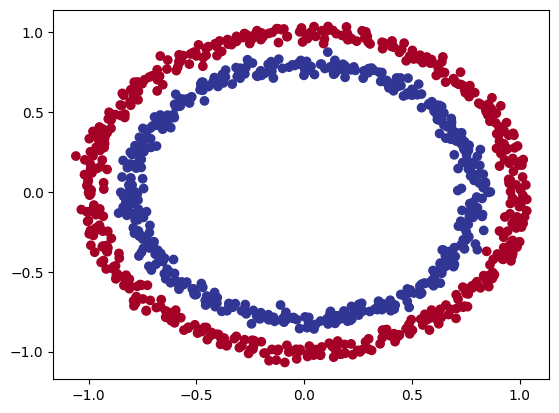

In [7]:
# Visualizando los datos
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)
# Con esto vemos que estamos trabajando en clasificación binaria

Note: the data we're working with often referred to as a toy dataset, a dataset that is small enought to experiment but still sizeable enough to practice the fundamentals


https://scikit-learn.org/stable/datasets/toy_dataset.html

### 1.1. Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [11]:
# Turn data into tensors
import torch
torch.__version__

'2.6.0+cu124'

In [12]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [13]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [15]:
torch.manual_seed(42)

In [16]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 80% training and 20% testing
                                                    random_state=42)

In [17]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [18]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelarator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Defining a loss function and optimizer
4. Create and training and test loop


In [19]:
# Import PyTorch and nn
import torch
from torch import nn

#Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
X_train, X_train.shape

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         ...,
         [ 0.0157, -1.0300],
         [ 1.0110,  0.1680],
         [ 0.5578, -0.5709]]),
 torch.Size([800, 2]))

 Now we've setup device agnostic code, let's create a model that:

 1. Subclasses `nn.Module` (almost all models in PyTorch are subclasses of `nn.Module`)
 2. Create 2 `nn.Linear()` layuers that are capable of handling the shapes of our data
 3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
 4. Instantiate an instance of our model class and send it to the target `device`


In [24]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shape of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    # Si sólo queremos una capa pondríamos salida 1, pero queremos una intermedia así
    # que por ejemplo ponemos salida 5 y será la entrada de la siguiente capa, este
    # número lo hemos elegido de forma aleatoriaaunque típicamente deben ser múltiplos de 8
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer and output a single feature

  # 3. Define a forward method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x->layer_1->layer_2

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
device

'cuda'

In [26]:
next(model_0.parameters()).device

device(type='cuda', index=0)

https://playground.tensorflow.org/


In [27]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0


Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [28]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [34]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1. Setup loss function and optimizer

Which loss function should we use?

Again... this is problem specific.

For example, for regression you might want MAE or MSE (mean absolute error or mean squared error).and
For classification, you might want binary cross entropy or category cross entropy.

https://pytorch.org/docs/stable/nn.html#loss-functions

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`
(Logit es una función que mapea probabilidades)
* For different optimnizers see `torch.optim`

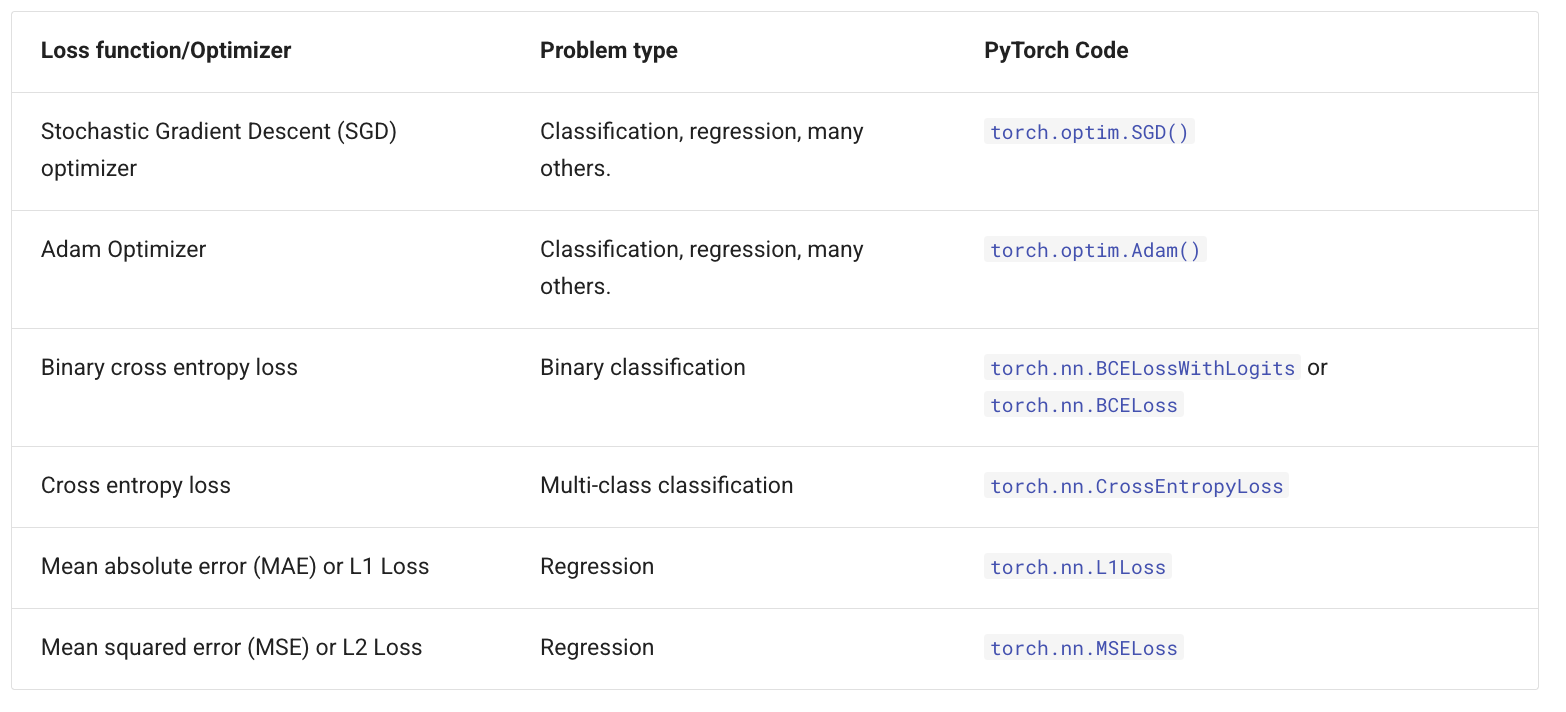

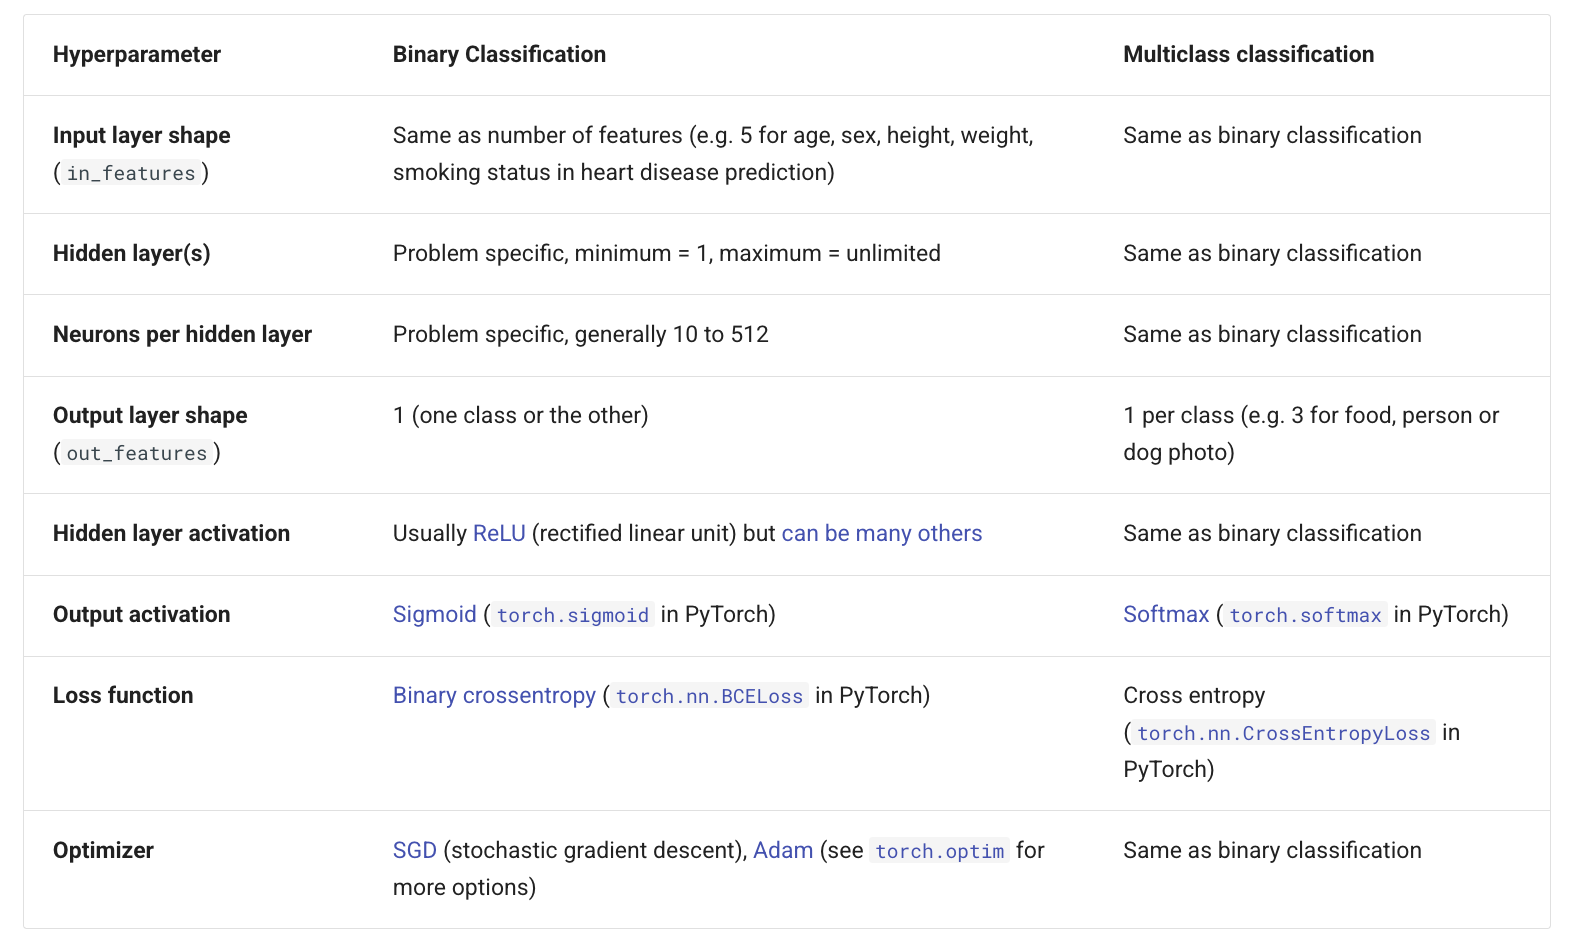

In [ ]:
# Setup the loss function
#loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone throgh the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

# Una función de activación, es una función que transmite la información generada por la combinación
# lineal de pesos y las entradas, es decir, son la manera de transmitir la información por las conexiones
# de salida. Normalmente introducen no linealidades, lo que permite a las redes neuronales
# aprender mapeos muy complejos entre entradas y salidas.


# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [35]:
# Calculate accuracy - out of 100 examples, what percentage doew our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## 3. Train model

To train our model, we're going to need to build a training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)



### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into predictions probabilities by passing them to some kind of activation function(e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking tha `argmax()`

In [37]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode() :
  y_logits = model_0(X_test.to(device))[:5]
y_logits

# Los logits son las salidas brutas de nuestro modelo sin pasar por ninguna función de activación
# Una función de activación es algo un poco separado de una capa

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0', grad_fn=<SliceBackward0>)

In [38]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [41]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

#Tenemos que utilizar una función de activación sigmoide para convertirlo en probabilidades de predicción

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0', grad_fn=<SigmoidBackward0>)

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)


In [50]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred_probs -> pred_labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [51]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)